In [1]:
%load_ext autoreload
%autoreload 2
name = 'logs/all-residual2-acc-adam-8e-4-e3p2--aug-bpe-2020-06-02-18-33-06/'

In [2]:
import torch
import os
import time
import random
import argparse
import numpy as np
import torch.nn.functional as F
import torchaudio
from models import Transducer
from tokenizer import HuggingFaceTokenizer, CharTokenizer
import json
import sounddevice as sd
import soundfile as sf
from recurrent import MFCC_
from pydub import AudioSegment, effects  
import tempfile
import queue
import sys

In [3]:
%matplotlib inline  
import matplotlib
import matplotlib.pylab as plt

In [4]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


In [5]:
import torchaudio
wav_file = '908-31957-0004.flac'
# wav_file= 'bloom.mp3'
texts = 'SHALL I NEVER MISS HOME TALK AND BLESSING AND THE COMMON KISS THAT COMES     TO EACH IN TURN NOR COUNT IT STRANGE WHEN I LOOK UP TO DROP ON A NEW RANGE OF WALLS AND FLOORS ANOTHER HOME THAN THIS'.lower()
data, sr = torchaudio.load(wav_file, normalization=True)
data = data[0]
print(sr)
transforms = MFCC_(
    sample_rate=sr,
    n_mfcc= 80,  log_mels=True,
    melkwargs={'n_fft': 512, 'f_min': 20, 'f_max': 5800 }
)
# transforms = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=400, f_min= 20, f_max= 5800)
# output = torchaudio.compliance.kaldi.mfcc(data.unsqueeze(0), 
#                                               sample_frequency=sr, num_mel_bins=80, num_ceps=80)
output = transforms(data).T#[ -1:, :]

16000


In [89]:
print(output.shape)
print(output.mean(), torch.var(output))

torch.Size([923, 80])
tensor(-0.6216) tensor(66.5573)


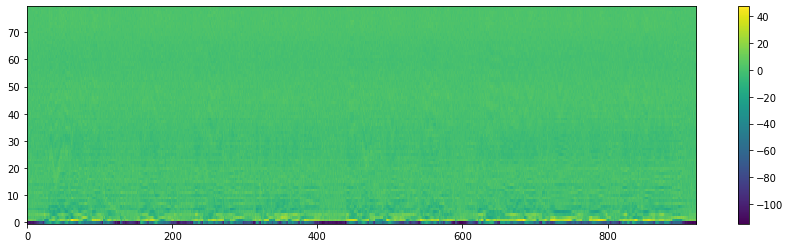

In [90]:
fig, ax = plt.subplots(figsize=(15, 4))
im = ax.imshow(output.T, aspect='auto', origin='lower',
               interpolation='none')
fig.colorbar(im, ax=ax)
plt.show()

In [50]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


torch.Size([43270, 80])
tensor(-1.7871) tensor(162.3249)


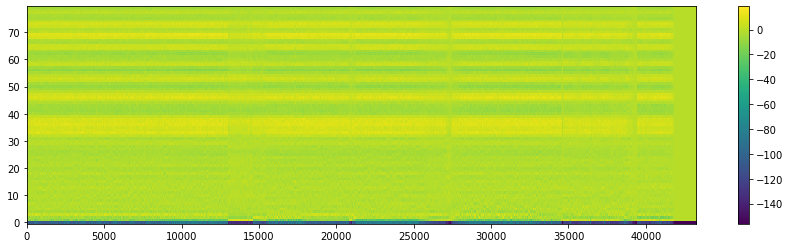

In [52]:
output = []
data, sr = torchaudio.load(wav_file, normalization=True)
data = data.T
for audio_data in chunks(data, 599*4+3 ):
    mfcc = transforms(audio_data[:, 0])
    output.append(mfcc.T)
output = torch.cat(output, dim=0)
print(output.shape)
print(output.mean(), torch.var(output))
fig, ax = plt.subplots(figsize=(15, 4))
im = ax.imshow(output.T, aspect='auto', origin='lower',
               interpolation='none')
fig.colorbar(im, ax=ax)
plt.show()

In [13]:
from parts.perturb import AudioAugmentor
from parts.features import AudioPreprocessing
wav_file = '908-31957-0004.flac'
texts = 'SHALL I NEVER MISS HOME TALK AND BLESSING AND THE COMMON KISS THAT COMES     TO EACH IN TURN NOR COUNT IT STRANGE WHEN I LOOK UP TO DROP ON A NEW RANGE OF WALLS AND FLOORS ANOTHER HOME THAN THIS'.lower()
# audio = AudioSegment.from_file(wav_file,
#                                target_sr=16000,
#                                int_values=False,
#                                offset=0, duration=0, trim=False)
# samples=torch.tensor(audio.samples, dtype=torch.float)
# num_samples = torch.tensor(samples.shape[0]).int()
# print(num_samples)
data, sr = torchaudio.load(wav_file, normalization=True)
data = data[0]
transform = AudioPreprocessing(normalize='none', sample_rate=16000, window_size=0.02, window_stride=0.015, features=80, n_fft=512, 
    feat_type='logfbank', trim_silence=True, window='hann',dither=0.00001, frame_splicing=1)
# time = len(data[0]) // sr
# print(torch.tensor(data.shape))
full_output = transform(data)
full_output = full_output.squeeze(0)
print(full_output.shape)

torch.Size([80, 984])


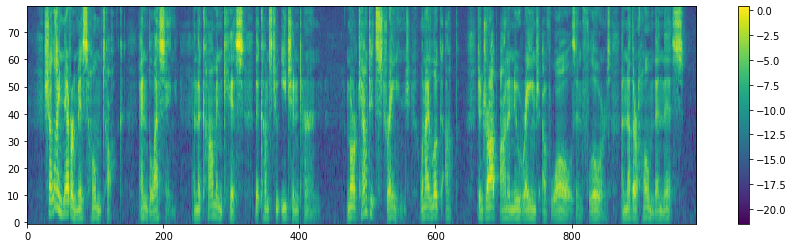

In [56]:
fig, ax = plt.subplots(figsize=(15, 4))
im = ax.imshow(full_output, aspect='auto', origin='lower',
               interpolation='none')
fig.colorbar(im, ax=ax)
plt.show()

In [45]:
mfcc = []
data, sr = torchaudio.load(wav_file, normalization=True)
data = data[0]
frames = 4
frame_size = (int(0.02*16000)*3)-1

print(frame_size)
data = data.T.numpy()

for audio_data in chunks(data, frame_size*frames + (frames-1)):
    # print(len(audio_data.flatten()))
    output = transform(torch.from_numpy(audio_data.flatten()).float()).T#[ -1:, :]
    # output = (output-torch.mean(output))/torch.var(output)
    # output = torch.from_numpy(cmvn(output.numpy(), variance_normalization=False))
    mfcc.append( output )

mfcc = torch.cat(mfcc).T
print(mfcc.shape)

959
torch.Size([80, 984])


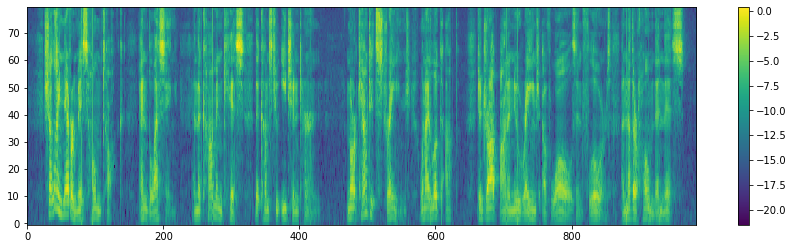

In [46]:
fig, ax = plt.subplots(figsize=(15, 4))
im = ax.imshow(mfcc, aspect='auto', origin='lower',
               interpolation='none')
fig.colorbar(im, ax=ax)
plt.show()

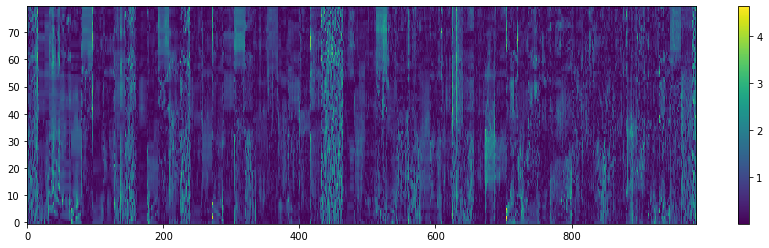

In [41]:
fig, ax = plt.subplots(figsize=(15, 4))
im = ax.imshow(torch.abs(mfcc-full_output), aspect='auto', origin='lower',
               interpolation='none')
fig.colorbar(im, ax=ax)
plt.show()

In [42]:
torch.abs(mfcc-full_output).mean()

tensor(0.6844)

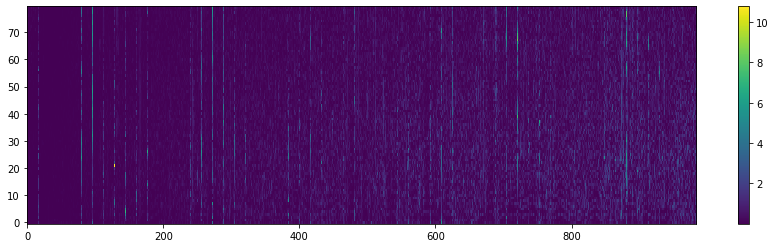

In [47]:
fig, ax = plt.subplots(figsize=(15, 4))
im = ax.imshow(torch.abs(mfcc-full_output), aspect='auto', origin='lower',
               interpolation='none')
fig.colorbar(im, ax=ax)
plt.show()

In [48]:
torch.abs(mfcc-full_output).mean()

tensor(0.3792)

In [6]:
from augmentation import ConcatFeature, TimeMask, FreqMask, TimeWrap
from parts.features import AudioPreprocessing

In [7]:
from dataset import ( Librispeech, MergedDataset, seq_collate)
from tokenizer import HuggingFaceTokenizer
from torch.utils.data import DataLoader

In [8]:
transforms_piplines = [
        AudioPreprocessing(
            normalize='none', sample_rate=16000, window_size=0.02, 
            window_stride=0.015, features=80, n_fft=512, log=True,
            feat_type='logfbank', trim_silence=True, window='hann',dither=0.00001, frame_splicing=1, transpose_out=False
        ),
        TimeWrap(),
        TimeMask(T=40, num_masks=5, replace_with_zero=False),
        FreqMask(F=5, num_masks=5, replace_with_zero=False),
    ]

transforms_piplines.append(
     ConcatFeature(merge_size=3)
)
transforms = torch.nn.Sequential(*transforms_piplines)

In [231]:
tokenizer = HuggingFaceTokenizer()
ls_dataset = Librispeech(
            'LibriSpeech/test-clean',
            transforms=transforms, tokenizer=tokenizer)

Use cleaner !
size 2262
hrs  3.3241666666666667


In [33]:
dataloader = iter(DataLoader(
            ls_dataset, collate_fn=seq_collate, batch_size=1,
            num_workers=4, shuffle=True))

b'\x80\x03K\x00]q\x00M\x13\x07a\x86q\x01.'b'\x80\x03K\x01]q\x00M-\x06a\x86q\x01.'
b'\x80\x03K\x02]q\x00MQ\x07a\x86q\x01.'

b'\x80\x03K\x03]q\x00M\xe3\x04a\x86q\x01.'
b'\x80\x03K\x06]q\x00M\xda\x06a\x86q\x01.'b'\x80\x03K\x05]q\x00K8a\x86q\x01.'

b'\x80\x03K\x04]q\x00M\xc6\x08a\x86q\x01.'
b'\x80\x03K\x07]q\x00M\xfa\x05a\x86q\x01.'
b'\x80\x03K\x08]q\x00M\x02\x01a\x86q\x01.'
b'\x80\x03K\t]q\x00M\xe6\x07a\x86q\x01.'
b'\x80\x03K\n]q\x00M\xa1\x05a\x86q\x01.'
b'\x80\x03K\x0b]q\x00M\xcf\x02a\x86q\x01.'
b'\x80\x03K\x0c]q\x00MD\x05a\x86q\x01.'
b'\x80\x03K\r]q\x00MT\x07a\x86q\x01.'
b'\x80\x03K\x0e]q\x00Kia\x86q\x01.'
b'\x80\x03K\x0f]q\x00M\xc2\x07a\x86q\x01.'
b'\x80\x03K\x10]q\x00M\xee\x01a\x86q\x01.'
b'\x80\x03K\x11]q\x00M\xc7\x03a\x86q\x01.'
b'\x80\x03K\x12]q\x00MX\x08a\x86q\x01.'


In [17]:
log_name = 'logs/all-residual2-clean-5e-4-e3p2-1000-bpe/'

class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)


best_checkpoint = os.path.join(log_name, 'amp_checkpoint.pt')
if not os.path.exists(best_checkpoint):
    raise ValueError('Not found')

checkpoint = torch.load(best_checkpoint, map_location= 'cpu')
with open(os.path.join(log_name, 'vars.json'), 'r') as f:
    params = json.load(f)
print('Checkpoint at epoch %d ' % checkpoint['epoch'])
args = Struct(**params)

sd.default.samplerate = 16000
duration = 60  # seconds

if args.tokenizer == 'char':
    _tokenizer = CharTokenizer()
else:
    _tokenizer = HuggingFaceTokenizer() # use BPE-400
    print('use bpe')

model = Transducer(args.audio_feat*3, _tokenizer.vocab_size,
        args.vocab_dim, # vocab embedding dim
        args.h_dim, # hidden dim
        args.layers, pred_num_layers=args.pred_layers, dropout=args.dropout).cpu()
model.load_state_dict(checkpoint['model'])

Checkpoint at epoch 6 
Use cleaner !
use bpe


<All keys matched successfully>

In [184]:
import math
import numpy as np

NEG_INF = -float("inf")
def logsumexp(*args):
    """
    Stable log sum exp.
    """
    if all(a == NEG_INF for a in args):
        return NEG_INF
    a_max = max(args)
    lsp = math.log(sum(math.exp(a - a_max)
                    for a in args))
    return a_max + lsp

def forward_pass(log_probs, labels, blank):

    T, U, _ = log_probs.shape
    alphas = np.zeros((T, U))

    for t in range(1, T):
        alphas[t, 0] = alphas[t-1, 0] + log_probs[t-1, 0, blank]

    for u in range(1, U):
        alphas[0, u] = alphas[0, u-1] + log_probs[0, u-1, labels[u-1]]
    for t in range(1, T):
        for u in range(1, U):
            no_emit = alphas[t-1, u] + log_probs[t-1, u, blank]
            emit = alphas[t, u-1] + log_probs[t, u-1, labels[u-1]]
            alphas[t, u] = logsumexp(emit, no_emit)

    loglike = alphas[T-1, U-1] + log_probs[T-1, U-1, blank]
    return alphas, loglike

def backward_pass(log_probs, labels, blank):

    T, U, _ = log_probs.shape
    betas = np.zeros((T, U))
    betas[T-1, U-1] = log_probs[T-1, U-1, blank]

    for t in reversed(range(T-1)):
        betas[t, U-1] = betas[t+1, U-1] + log_probs[t, U-1, blank]

    for u in reversed(range(U-1)):
        betas[T-1, u] = betas[T-1, u+1] + log_probs[T-1, u, labels[u]]

    for t in reversed(range(T-1)):
        for u in reversed(range(U-1)):
            no_emit = betas[t+1, u] + log_probs[t, u, blank]
            emit = betas[t, u+1] + log_probs[t, u, labels[u]]
            betas[t, u] = logsumexp(emit, no_emit)

    return betas, betas[0, 0]

In [249]:
xs, ys, xlen, ylen = next(dataloader)
print(ylen)

b'\x80\x03K\n(ctorch.multiprocessing.reductions\nrebuild_tensor\nq\x00ctorch\nTensor\nq\x01ctorch.multiprocessing.reductions\nrebuild_storage_filename\nq\x02(ctorch\nFloatStorage\nq\x03CG/var/folders/tm/7_wpm1dx3c5_1394wrgs60w40000gn/T//torch-shm-file-qSnrrxq\x04C\x17/torch_65296_3172100205q\x05M\xb0^tq\x06Rq\x07(K\x00ctorch\nSize\nq\x08K\x01KeK\xf0\x87q\t\x85q\nRq\x0bM\xb0^K\xf0K\x01\x87q\x0c\x89tq\r\x87q\x0eRq\x0fh\x00h\x01h\x02(ctorch\nLongStorage\nq\x10CG/var/folders/tm/7_wpm1dx3c5_1394wrgs60w40000gn/T//torch-shm-file-qSnrrxq\x11C\x17/torch_65296_3558086355q\x12K\x15tq\x13Rq\x14(K\x00h\x08K\x01K\x15\x86q\x15\x85q\x16Rq\x17K\x15K\x01\x86q\x18\x89tq\x19\x87q\x1aRq\x1bh\x00h\x01h\x02(ctorch\nIntStorage\nq\x1cCG/var/folders/tm/7_wpm1dx3c5_1394wrgs60w40000gn/T//torch-shm-file-qSnrrxq\x1dC\x17/torch_65296_3656239273q\x1eK\x01tq\x1fRq (K\x00h\x08K\x01\x85q!\x85q"Rq#K\x01\x85q$\x89tq%\x87q&Rq\'h\x00h\x01h\x02(h\x1cCG/var/folders/tm/7_wpm1dx3c5_1394wrgs60w40000gn/T//torch-shm-file-qSnrrxq(C

In [250]:
y = np.array(list(range(len(ys[0]))))
y_labels = [tokenizer.token.id_to_token(t)  for t in ys[0].data.numpy()] 

In [251]:
alignment_output = model(xs, ys, xlen, ylen)[0]

In [252]:
print(alignment_output.shape)

torch.Size([51, 22, 1024])


In [253]:
alignment_log_prob = torch.log_softmax(alignment_output, dim=-1).data.numpy()
alphas, _ = forward_pass(alignment_log_prob, ys[0].data.numpy(), 0)
alphas = alphas/(np.min(alphas)*-1)
print(alphas.shape)
betas, _ = backward_pass(alignment_log_prob, ys[0].data.numpy(), 0)
betas = betas/(np.min(betas)*-1)

(51, 22)


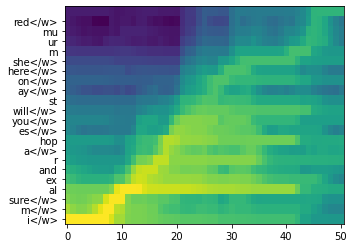

In [268]:
fig, ax = plt.subplots(figsize=(5, 4))

im = ax.imshow(np.exp(alphas).T, aspect='auto', origin='lower',
               interpolation='none')
plt.yticks(y, y_labels)

plt.show()

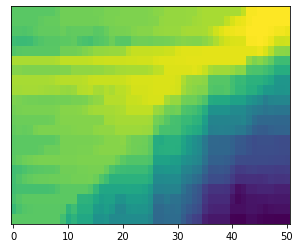

In [267]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_yticks([])
im = ax.imshow(np.exp(betas).T, aspect='auto', origin='lower',
               interpolation='none')
plt.show()

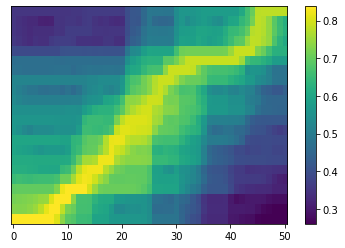

In [266]:
fig, ax = plt.subplots(figsize=(6.2, 4))
ax.set_yticks([])
im = ax.imshow((np.exp(betas).T)*(np.exp(alphas).T), aspect='auto', origin='lower',
               interpolation='none')
fig.colorbar(im, ax=ax)
plt.show()

In [173]:
alignment_soft = torch.softmax(alignment_output, dim=-1)
print(alignment_soft.shape)
test_align = alignment_soft[:, :-1, :]
character_prob = torch.zeros((test_align.shape[0], test_align.shape[1]))

for idx in range(test_align.shape[0]):
    for idy in range(test_align.shape[1]):
        character_prob[idx][idy] = alignment_soft[idx][idy][ys_[idx][idy] ]
        
null_prob = torch.zeros((test_align.shape[0], test_align.shape[1]))
for idx in range(test_align.shape[0]):
    for idy in range(test_align.shape[1]):
        null_prob[idx][idy] = alignment_soft[idx][idy][0]

        
forward_prob = torch.zeros((test_align.shape[0], test_align.shape[1]))

        

torch.Size([102, 46, 1024])


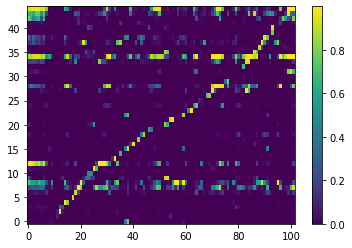

In [174]:
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(alignment_prob.data.numpy().T, aspect='auto', origin='lower',
               interpolation='none')
fig.colorbar(im, ax=ax)
plt.show()

In [134]:
alignment = alignment_soft.mean(dim=-1)

In [135]:
forward_alignment = alignment[:-1, :]-alignment[1:, :]
forward_alignment = forward_alignment[:, :-1] - forward_alignment[:, 1:]

In [136]:
backward_alignment = alignment[1:, :]-alignment[:-1, :]
backward_alignment = backward_alignment[:, 1:] - backward_alignment[:, :-1]

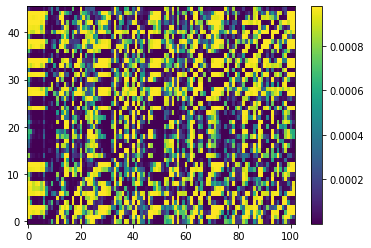

In [140]:
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(alignment.data.numpy().T, aspect='auto', origin='lower',
               interpolation='none')
fig.colorbar(im, ax=ax)
plt.show()

torch.Size([88, 34])